# FINAL PROJECT

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
from tqdm import tqdm
from xgboost import XGBClassifier
from graphviz import Source

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, auc, roc_curve, classification_report

warnings.filterwarnings('ignore')

# read the dataset
df = pd.read_csv("promotions.csv")

### A glimpse into the data

In [2]:
row ,columns = df.shape
print(f"rows: {row}\ncolumns: {columns}")

rows: 54808
columns: 14


In [3]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


### Exploring the Data

In [4]:
def show_dist_graphs(col):
    fig, axes = plt.subplots(ncols=3,figsize=(15,5))
    fig.tight_layout(pad=0.4, w_pad=2.346, h_pad=1.0)
    df.groupby([col]).sum()['is_promoted'].plot(ax=axes[0])
    df.groupby([col]).mean()['is_promoted'].plot(ax=axes[1])
    df.groupby([col]).count()['employee_id'].plot(ax=axes[2])
    axes[0].title.set_text('Distribution of promoted by '+col+ ' - sum')
    axes[1].title.set_text('Distribution of employees by '+col+ ' - mean')
    axes[2].title.set_text('Distribution of employees by '+col)
    axes[0].set_ylabel('Sum of is_promoted',fontsize = 10)
    axes[1].set_ylabel('Mean of is_promoted',fontsize = 10)
    axes[2].set_ylabel('count of employees',fontsize = 10)

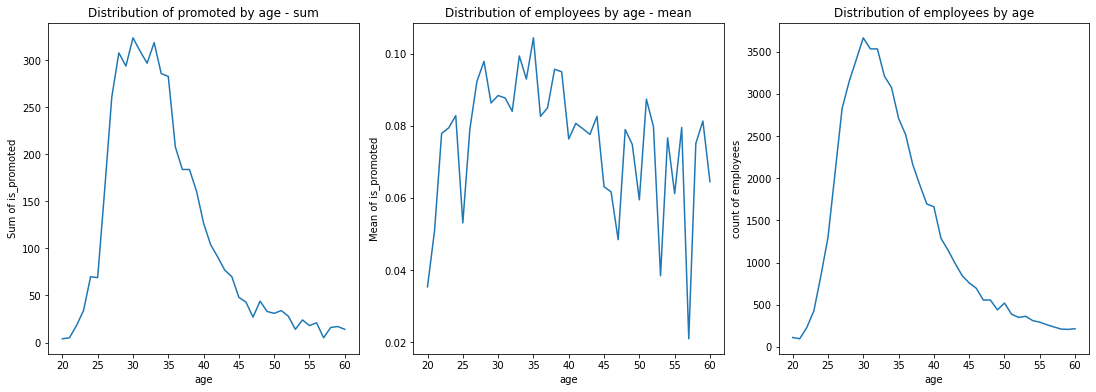

In [5]:
show_dist_graphs('age')

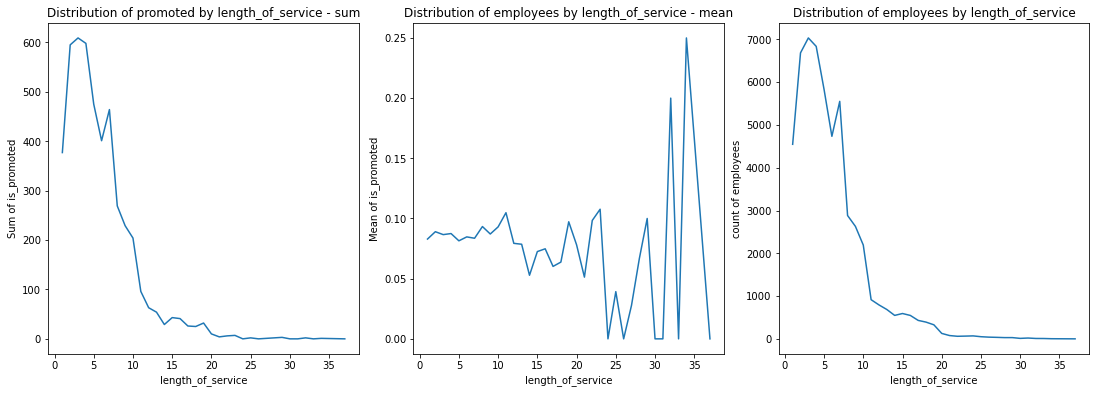

In [6]:
show_dist_graphs('length_of_service')

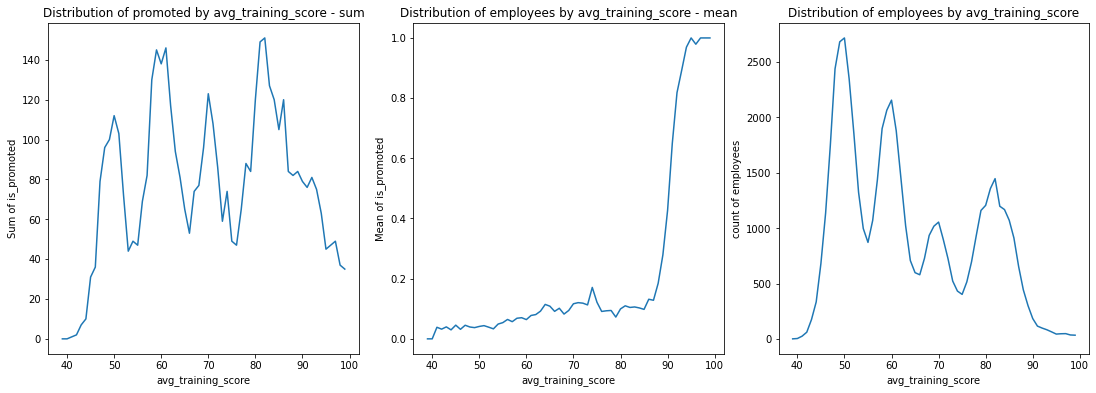

In [7]:
show_dist_graphs('avg_training_score')

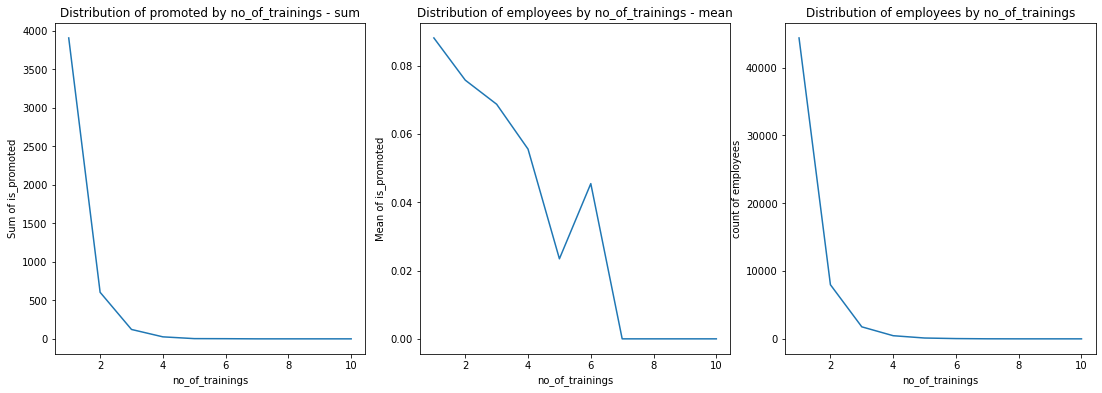

In [8]:
show_dist_graphs('no_of_trainings')

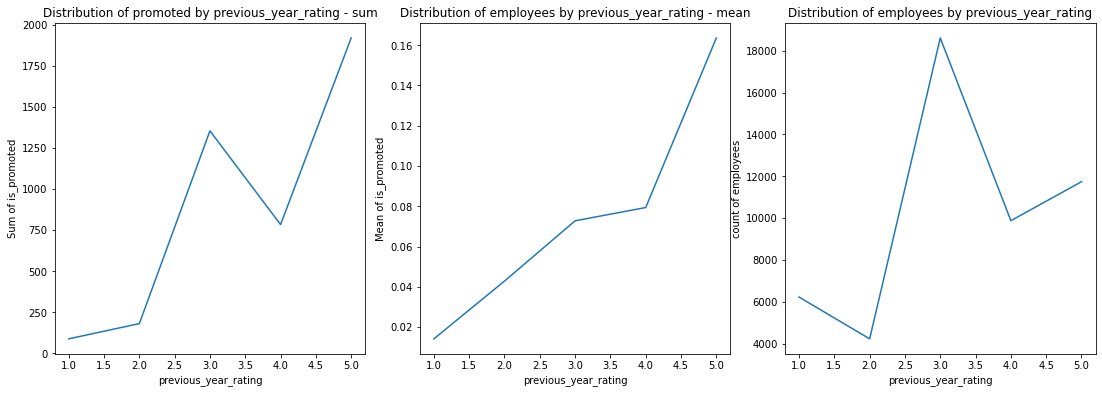

In [9]:
show_dist_graphs('previous_year_rating')

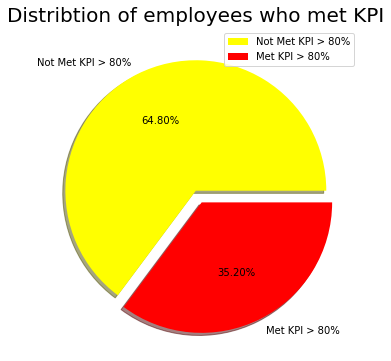

In [10]:
# plotting a pie chart
metKPI = df['KPIs_met >80%'].sum()
size = [row - metKPI, metKPI]
labels = "Not Met KPI > 80%", "Met KPI > 80%"
colors = ['yellow', 'red']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (6, 6)
plt.pie(size, labels = labels, colors = colors, explode = explode, shadow = True, autopct = "%.2f%%")
plt.title('Distribtion of employees who met KPI', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

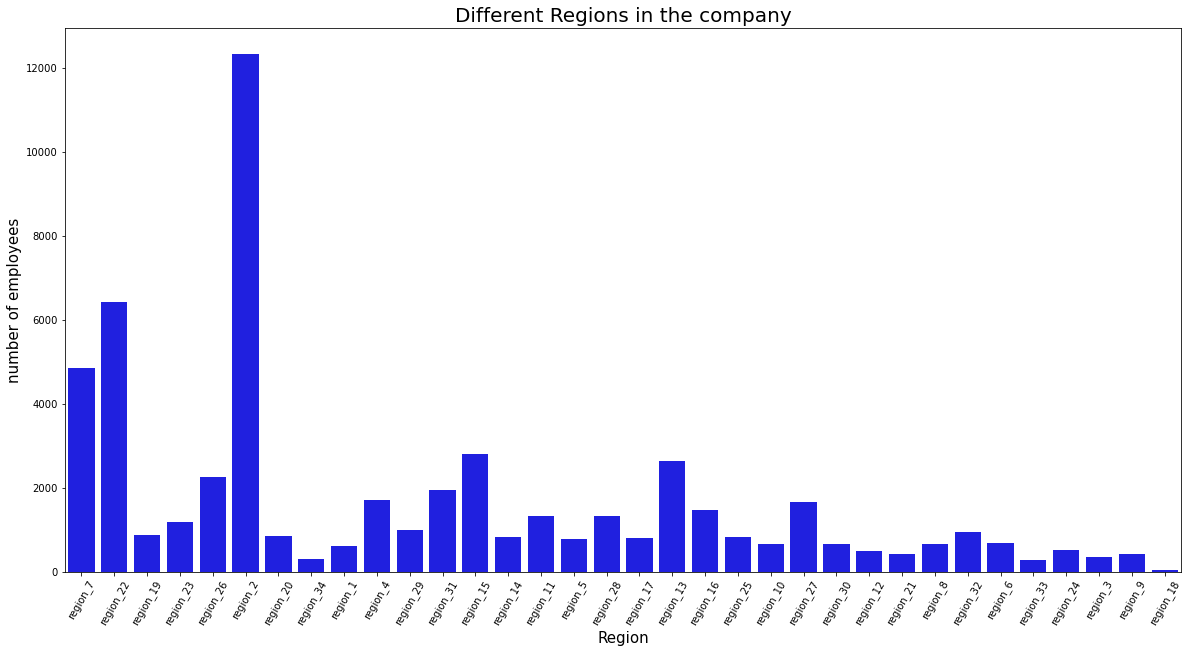

In [11]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.countplot(df['region'], color = 'blue')
plt.title('Different Regions in the company', fontsize = 20)
plt.xticks(rotation = 60)
plt.xlabel('Region', fontsize = 15)
plt.ylabel('number of employees', fontsize = 15)
plt.show()

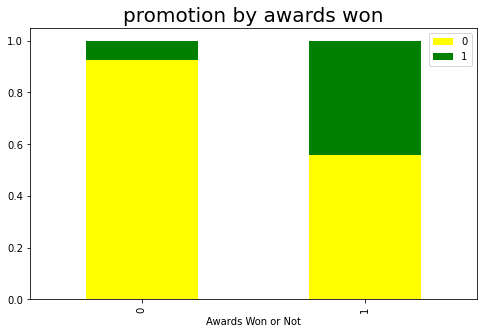

In [12]:
#  promotion by awards won

data = pd.crosstab(df['awards_won?'], df['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (8, 5), color = ['yellow', 'green'])

plt.title('promotion by awards won', fontsize = 20)
plt.xlabel('Awards Won or Not', fontsize = 10)
plt.legend()
plt.show()

### Feature Engineering

In [13]:
# check and fill missing values
df.isna().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [14]:
df['education'].fillna(df.education.mode()[0],inplace=True)
df['previous_year_rating'].fillna(df.previous_year_rating.median(),inplace=True)

In [15]:
df.isna().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

In [16]:
df.age.describe()

count    54808.000000
mean        34.803915
std          7.660169
min         20.000000
25%         29.000000
50%         33.000000
75%         39.000000
max         60.000000
Name: age, dtype: float64

In [17]:
## encoding "region" columns
labelEncoder1 = LabelEncoder()
labelEncoder1.fit(df['region'])
df['region'] = labelEncoder1.transform(df['region'])

# add dummy variables
dummies = df[['gender','education','recruitment_channel','department']]
dummies = pd.get_dummies(dummies)
data = pd.concat([df.drop(['employee_id','gender','education','recruitment_channel','department'],axis=1),dummies],axis=1)


data.loc[data.age<=29,'age'] = 1
data.loc[(data.age>29) & (data.age<=33),'age'] = 2
data.loc[(data.age>33) & (data.age<=39),'age'] = 3
data.loc[data.age>39,'age'] = 4

data['train_score>90'] = 0
data.loc[data['avg_training_score']>=90,'train_score>90'] = 1

# adding polynomial features ----> didnt work well
#data['length_of_service_sq'] = data.length_of_service**2
#data['age_sq'] = data.age**2
#data['ln_train_score'] = np.log(data['avg_training_score'])

# adding all possible interaction features - more then 1800 feature ---> didnt work well
#from itertools import combinations
#interactions = {i[0]+'_'+i[1]:i for i in list(combinations(list(data.columns), 2)) if 'is_promoted' not in i}
#for i in interactions.items():
#    data[i[0]] = data[i[1][0]]*data[i[1][1]]
    
#### we tried to transform no_of_trainings to boolean - didnt work well
#data['no_of_trainings<2'] = 0
#data.loc[data['no_of_trainings']>=2,'no_of_trainings<2'] = 1

#data = data.drop(['no_of_trainings','avg_training_score'],axis=1)

w,h = data.shape
print(f"rows: {w}\ncolumns: {h}")

rows: 54808
columns: 27


# FEATURE SELECTION

In [18]:
X = data.drop('is_promoted',axis=1)
y = data['is_promoted']

In [19]:
## we tried to scaled te data for all the model but except from the KNN all the scores of the other models(the good ones) went down  
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

In [20]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
#1 feature selection
def foo1(X,y,method,j):
    rfe = RFE(estimator=method, n_features_to_select=j)
    # fit RFE
    Xnew = rfe.fit_transform(X, y)
    #print([X.columns[i] for i in range(len(rfe.support_)) if rfe.support_[i]==True])
    Xnewnewnew = pd.DataFrame(Xnew, index=X.index, columns=[X.columns[i] for i in range(len(rfe.support_)) if rfe.support_[i]==True])
    # summarize all features
    #for i in range(X.shape[1]):
    #    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
    return Xnewnewnew, rfe.ranking_

#2 create variables with features
def foo2(data,y,size):
    return train_test_split(data, y, test_size=size,random_state=0)

#3 take the features and put in model
def foo3(model,X_train, X_test, y_train, y_test):
    clf = model
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    f1 = f1_score(y_test,y_test_pred)
    precision = precision_score(y_test,y_test_pred)
    recall = recall_score(y_test,y_test_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    
    
    return y_train_pred,y_test_pred, f1 ,precision, recall,auc(fpr,tpr), clf


In [21]:

r = range(1, X.shape[1]+1)
c = range(0,4)
bestf1 = 0
best_i =0
for i in tqdm(r):
    ## we use XGBClassifier for the selction because this it gives the best result
    t1 = foo1(X,y,XGBClassifier(n_estimators=100, max_depth=3,scale_pos_weight=2,verbosity=0),i)
    X_train, X_test, y_train, y_test = foo2(t1[0],y,0.3)
    y_train_pred,y_test_pred, f1 ,precision, recall,auc1, clf = foo3(XGBClassifier(n_estimators=100, 
                                                                                   max_depth=3,
                                                                                   scale_pos_weight=2,
                                                                                  verbosity=0),
                                                                             X_train, X_test, y_train, y_test)
    if bestf1<f1:
        best = (X_train, X_test, y_train, y_test,y_train_pred,y_test_pred, f1 ,precision, recall,auc1, clf,t1[1],t1[0])
        bestf1 = f1
        best_i = i
    


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [01:44<00:00,  4.03s/it]


In [22]:
X_train, X_test, y_train, y_test = best[0:4]
len(X_train)

38365

### Classification baseline - benchmark

In [23]:
def get_benchmark_predictions(x, benchmark_value):
    # returns a numpy array on the same length as x with all values equal to benchmark_value
    return np.ones(len(x))*benchmark_value

def confu(y_test_old,y_test_pred):
    cm = confusion_matrix(y_test_old,y_test_pred)
    sns.heatmap(cm,annot=True,fmt=".1f")

benchmark_value = 0

y_train_pred = get_benchmark_predictions(X_train, benchmark_value)
y_test_pred = get_benchmark_predictions(X_test, benchmark_value)

f1 = f1_score(y_test, y_test_pred)

print("f1 score:", f1)

f1 score: 0.0


precision: 0.9157088122605364
recall: 1.0
f1: 0.956


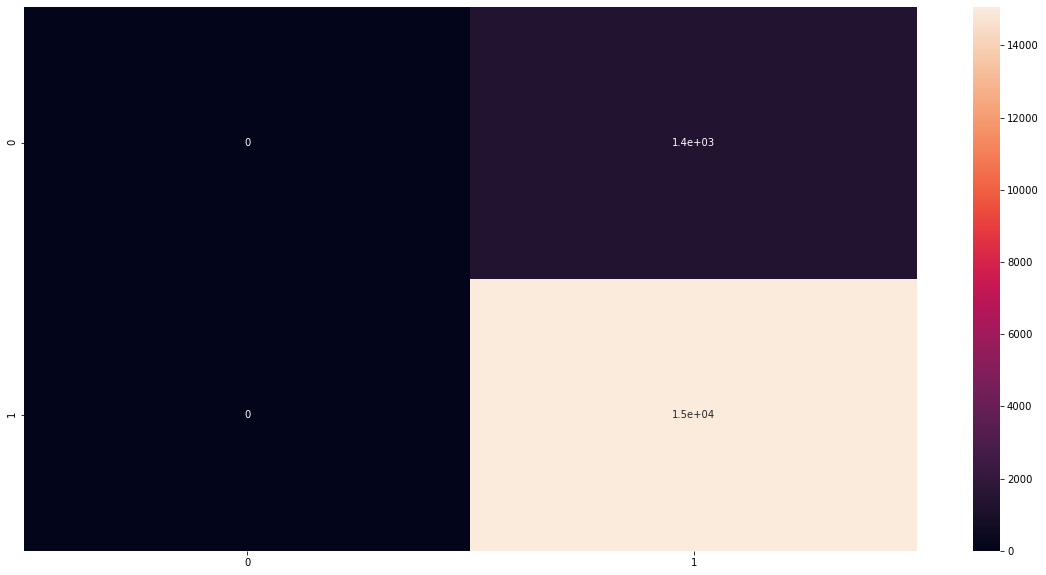

In [24]:
def mirror(seq):
    return np.array([cm[1][::-1] ,cm[0][::-1]])

cm = confusion_matrix(y_test,y_test_pred)
sns.heatmap(mirror(cm),annot=True)
precision = cm[0,0]/(cm[0,0]+cm[1,0])
recall = cm[0,0]/(cm[0,0]+cm[0,1])
f1 = 2*((precision*recall)/(precision+recall))
print(f"precision: {precision}\nrecall: {recall}\nf1: {f1}")

### KNN Model


In [25]:
models = {}

for i in range(2,5):
    y_train_pred_knn,y_test_pred_knn, f1_knn, precision_knn, recall_knn, t_auc_knn, clf_knn = foo3(KNeighborsClassifier(n_neighbors=i),
                                                                                             X_train, X_test, y_train, y_test)
    models[f'knn_{i}'] = y_train_pred_knn,y_test_pred_knn, f1_knn, precision_knn, recall_knn, t_auc_knn, clf_knn
    print('model:', f'knn_{i}')
    print("AUC:",t_auc_knn,"f1 score:",f1_knn)
    print("precision:",precision_knn,"recall:",recall_knn)

model: knn_2
AUC: 0.6469219994324596 f1 score: 0.44031830238726793
precision: 0.8316633266533067 recall: 0.2994227994227994
model: knn_3
AUC: 0.6668719472066753 f1 score: 0.4507819687212512
precision: 0.6218274111675127 recall: 0.35353535353535354
model: knn_4
AUC: 0.6428918594190561 f1 score: 0.4324034334763949
precision: 0.8430962343096234 recall: 0.2907647907647908


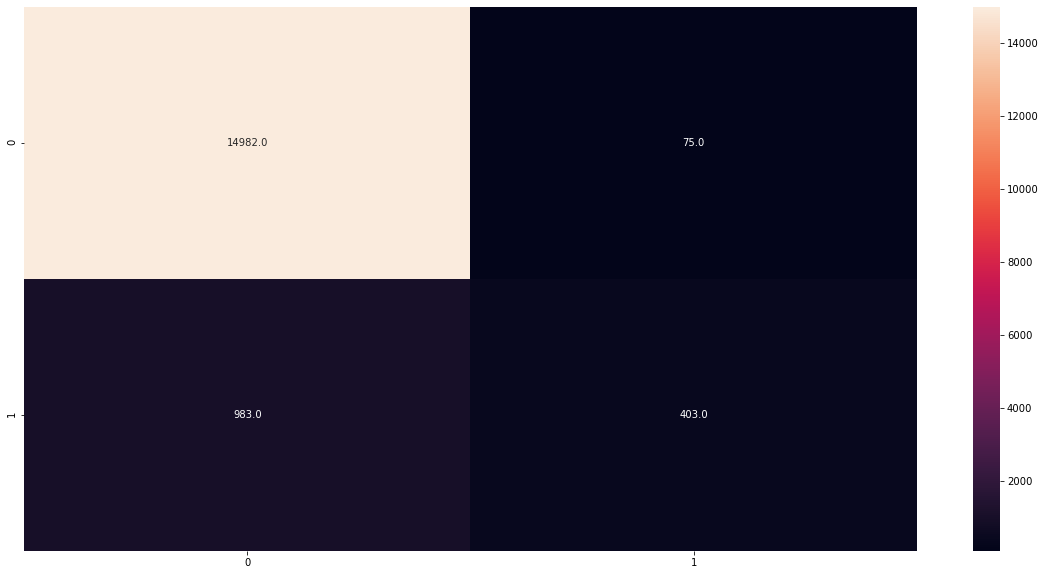

In [26]:
confu(y_test,y_test_pred_knn)

### KNN model with scaled values

In [27]:
for i in range(2,5):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train_pred_knn_scaled,y_test_pred_knn_scaled, f1_knn_scaled,precision_knn_scaled, recall_knn_scaled,t_auc_knn_scaled, clf_knn_scaled = foo3(KNeighborsClassifier(n_neighbors=i),
                                                                                                                                                  X_train_scaled, X_test_scaled, y_train, y_test)
    models[f'scaled_knn_{i}'] = y_train_pred_knn_scaled,y_test_pred_knn_scaled, f1_knn_scaled,precision_knn_scaled, recall_knn_scaled,t_auc_knn_scaled, clf_knn_scaled
    
    print('model:', f'scaled_knn_{i}')
    print("AUC:",t_auc_knn_scaled,"f1 score:",f1_knn_scaled)
    print("precision:",precision_knn_scaled,"recall:",recall_knn_scaled)

model: scaled_knn_2
AUC: 0.6475016150748368 f1 score: 0.437597911227154
precision: 0.7920604914933838 recall: 0.3023088023088023
model: scaled_knn_3
AUC: 0.6671376043760981 f1 score: 0.45244690674053556
precision: 0.6282051282051282 recall: 0.35353535353535354
model: scaled_knn_4
AUC: 0.640494907231309 f1 score: 0.42573726541554957
precision: 0.8288100208768268 recall: 0.28643578643578643


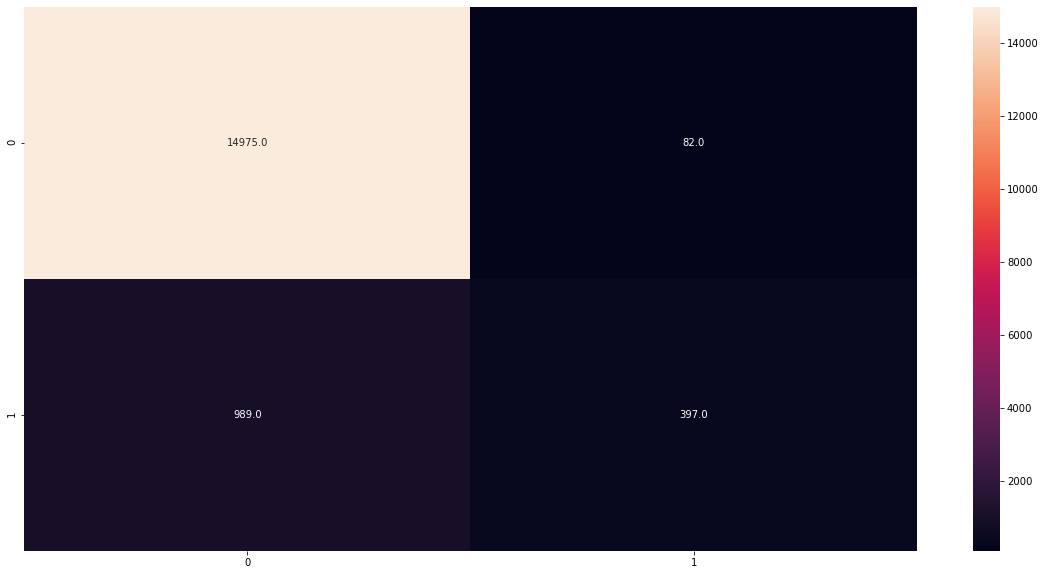

In [28]:
confu(y_test,y_test_pred_knn_scaled)


### Tree Model

In [29]:
for i in range(2,5):
    y_train_pred_tree,y_test_pred_tree, f1_tree ,precision_tree, recall_tree,t_auc_tree, clf_tree = foo3(DecisionTreeClassifier(max_depth=i,random_state=0),
                                                                                              X_train, X_test, y_train, y_test)
    models[f'tree_{i}'] = y_train_pred_tree,y_test_pred_tree, f1_tree ,precision_tree, recall_tree,t_auc_tree, clf_tree
    print('model:', f'tree_{i}')
    print("AUC:",t_auc_tree,"f1 score:",f1_tree)
    print("precision:",precision_tree,"recall:",recall_tree)

model: tree_2
AUC: 0.5547917911934649 f1 score: 0.1970569417786308
precision: 0.8700564971751412 recall: 0.1111111111111111
model: tree_3
AUC: 0.5501443001443002 f1 score: 0.1822950819672131
precision: 1.0 recall: 0.10028860028860029
model: tree_4
AUC: 0.5824322121393252 f1 score: 0.28019323671497587
precision: 0.8592592592592593 recall: 0.1673881673881674


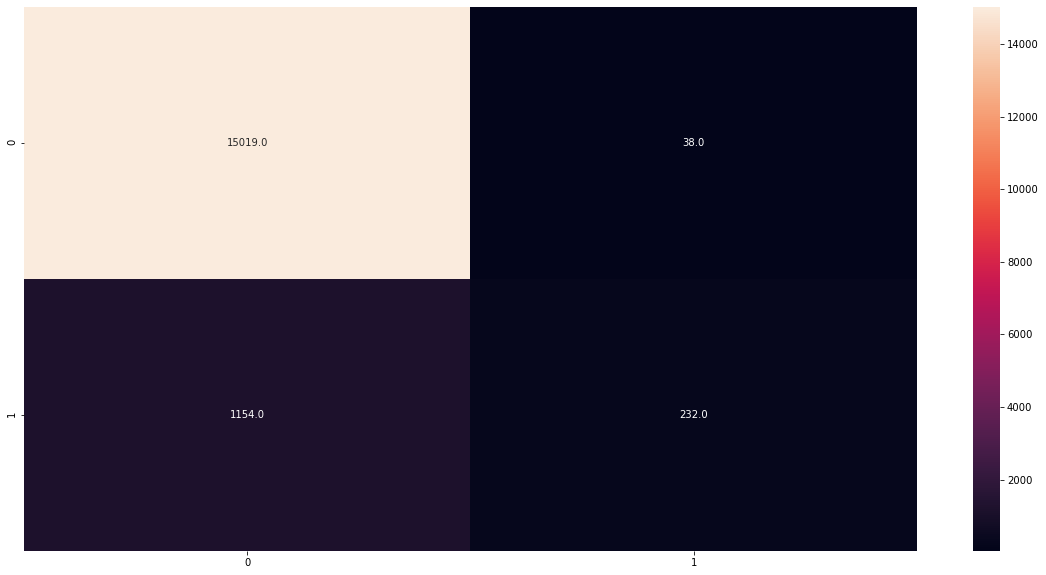

In [30]:
confu(y_test,y_test_pred_tree)

### Random Forest Model

In [31]:
for i in range(2,5):
    y_train_pred_rf,y_test_pred_rf, f1_rf ,precision_rf, recall_rf,t_auc_rf, clf_rf  = foo3(RandomForestClassifier(n_estimators=100, max_depth=i),
                                                                                        X_train, X_test, y_train, y_test)
    models[f'random_forest_{i}'] = y_train_pred_rf,y_test_pred_rf, f1_rf ,precision_rf, recall_rf,t_auc_rf, clf_rf
    
    print('model:', f'random_forest_{i}')
    print("AUC:",t_auc_rf,"f1 score:",f1_rf)
    print("precision:",precision_rf,"recall:",recall_rf)

model: random_forest_2
AUC: 0.5057720057720058 f1 score: 0.02282453637660485
precision: 1.0 recall: 0.011544011544011544
model: random_forest_3
AUC: 0.5534861465823809 f1 score: 0.1931302657161374
precision: 0.9490445859872612 recall: 0.1075036075036075
model: random_forest_4
AUC: 0.5568989355600235 f1 score: 0.20426632191338076
precision: 0.9813664596273292 recall: 0.113997113997114


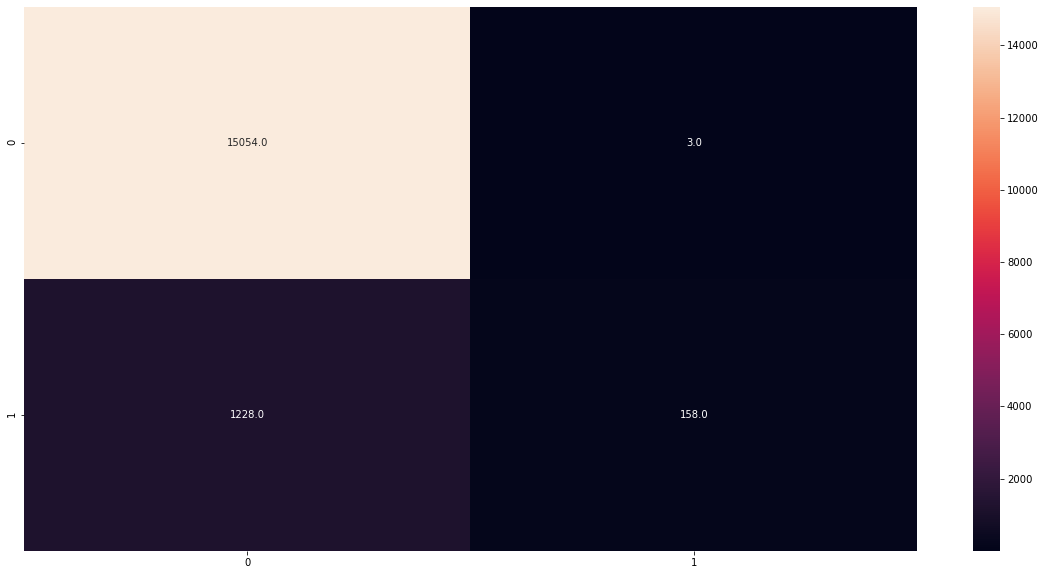

In [32]:
confu(y_test,y_test_pred_rf)

###  Ada Boost Model

In [33]:
for i in range(2,5):
    lf = DecisionTreeClassifier(max_depth=i)
    y_train_pred_ada,y_test_pred_ada, f1_ada, precision_ada, recall_ada, t_auc_ada, clf_ada = foo3(AdaBoostClassifier(lf,n_estimators=100, random_state=0),
                                                                                               X_train, X_test, y_train, y_test)
    models[f'ada_{i}'] = y_train_pred_ada,y_test_pred_ada, f1_ada, precision_ada, recall_ada, t_auc_ada, clf_ada
    
    print('model:', f'ada_{i}')
    print("AUC:",t_auc_ada,"f1 score:",f1_ada)
    print("precision:",precision_ada,"recall:",recall_ada)

model: ada_2
AUC: 0.6729805526876657 f1 score: 0.5065547981122182
precision: 0.927063339731286 recall: 0.3484848484848485
model: ada_3
AUC: 0.6819283691668628 f1 score: 0.5231243576567318
precision: 0.9089285714285714 recall: 0.36724386724386726
model: ada_4
AUC: 0.6833155222276561 f1 score: 0.5151665837891596
precision: 0.8288 recall: 0.37373737373737376


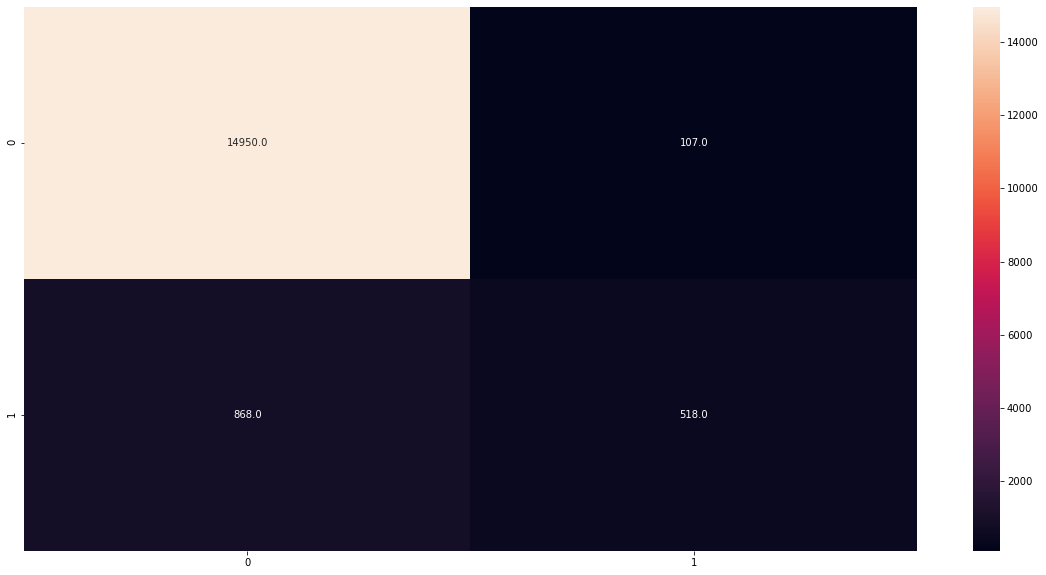

In [34]:
confu(y_test,y_test_pred_ada)

### XGBoost

In [35]:
for i in range(2,5):
    y_train_pred_xgb,y_test_pred_xgb, f1_xgb ,precision_xgb, recall_xgb,t_auc_xgb, clf_xgb  = foo3(XGBClassifier(n_estimators=100, max_depth=i,scale_pos_weight=2),
                                                                                         X_train, X_test, y_train, y_test)
    models[f'xgb_{i}'] = y_train_pred_xgb,y_test_pred_xgb, f1_xgb ,precision_xgb, recall_xgb,t_auc_xgb, clf_xgb
    print('model:', f'xgb_{i}')
    print("AUC:",t_auc_xgb,"f1 score:",f1_xgb)
    print("precision:",precision_xgb,"recall:",recall_xgb)

model: xgb_2
AUC: 0.6765125855084014 f1 score: 0.5095213587236233
precision: 0.8886894075403949 recall: 0.35714285714285715
model: xgb_3
AUC: 0.6888022484256795 f1 score: 0.531
precision: 0.8648208469055375 recall: 0.38311688311688313
model: xgb_4
AUC: 0.6893199780229068 f1 score: 0.5287128712871287
precision: 0.8422712933753943 recall: 0.3852813852813853


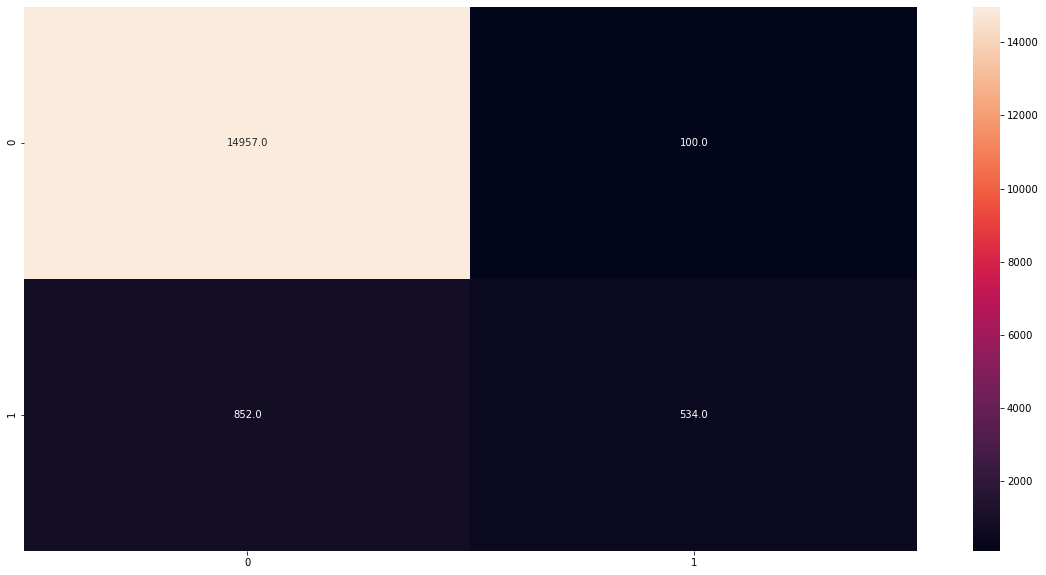

In [36]:
confu(y_test,y_test_pred_xgb)

### CatBoost

In [37]:
for i in range(2,5):
    y_train_pred_catboost,y_test_pred_catboost, f1_catboost ,precision_catboost, recall_catboost,t_auc_catboost, clf_catboost  = foo3(CatBoostClassifier(iterations=50, learning_rate=1, depth=i),
                                                                                                                                  X_train, X_test, y_train, y_test)
    models[f'cat_{i}'] = y_train_pred_catboost,y_test_pred_catboost, f1_catboost ,precision_catboost, recall_catboost,t_auc_catboost, clf_catboost
    print('model:', f'cat_{i}')
    print("AUC:",t_auc_catboost,"f1 score:",f1_catboost)
    print("precision:",precision_catboost,"recall:",recall_catboost)

0:	learn: 0.3000922	total: 157ms	remaining: 7.69s
1:	learn: 0.2513467	total: 159ms	remaining: 3.82s
2:	learn: 0.2369226	total: 161ms	remaining: 2.52s
3:	learn: 0.2252736	total: 163ms	remaining: 1.87s
4:	learn: 0.2212990	total: 164ms	remaining: 1.48s
5:	learn: 0.2195977	total: 166ms	remaining: 1.22s
6:	learn: 0.2130656	total: 168ms	remaining: 1.03s
7:	learn: 0.2121618	total: 170ms	remaining: 891ms
8:	learn: 0.2107732	total: 172ms	remaining: 782ms
9:	learn: 0.2058263	total: 174ms	remaining: 694ms
10:	learn: 0.1946772	total: 175ms	remaining: 622ms
11:	learn: 0.1930307	total: 177ms	remaining: 561ms
12:	learn: 0.1926632	total: 179ms	remaining: 510ms
13:	learn: 0.1922763	total: 181ms	remaining: 465ms
14:	learn: 0.1870429	total: 183ms	remaining: 427ms
15:	learn: 0.1864927	total: 185ms	remaining: 392ms
16:	learn: 0.1858896	total: 186ms	remaining: 362ms
17:	learn: 0.1806906	total: 188ms	remaining: 335ms
18:	learn: 0.1796000	total: 190ms	remaining: 310ms
19:	learn: 0.1779706	total: 192ms	remaini

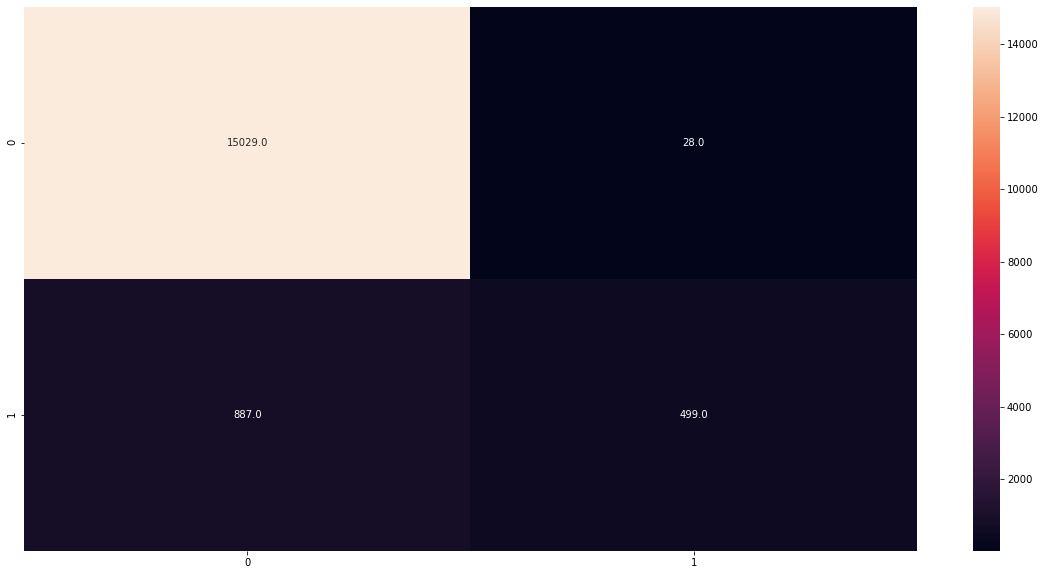

In [38]:
confu(y_test,y_test_pred_catboost)

### LightBoost

In [39]:
for i in range(2,5):
    y_train_pred_light,y_test_pred_light, f1_light ,precision_light, recall_light,t_auc_light, clf_light = foo3(LGBMClassifier(max_depth=i),
                                                                                                    X_train, X_test, y_train, y_test)
    models[f'light_{i}'] = y_train_pred_light,y_test_pred_light, f1_light ,precision_light, recall_light,t_auc_light, clf_light
    print('model:', f'light_{i}')
    print("AUC:",t_auc_light,"f1 score:",f1_light)
    print("precision:",precision_light,"recall:",recall_light)

model: light_2
AUC: 0.6269795987369209 f1 score: 0.4034285714285714
precision: 0.9697802197802198 recall: 0.2546897546897547
model: light_3
AUC: 0.6588871379666359 f1 score: 0.47913279132791325
precision: 0.9629629629629629 recall: 0.3189033189033189
model: light_4
AUC: 0.6726288588213275 f1 score: 0.5100956429330499
precision: 0.967741935483871 recall: 0.3463203463203463


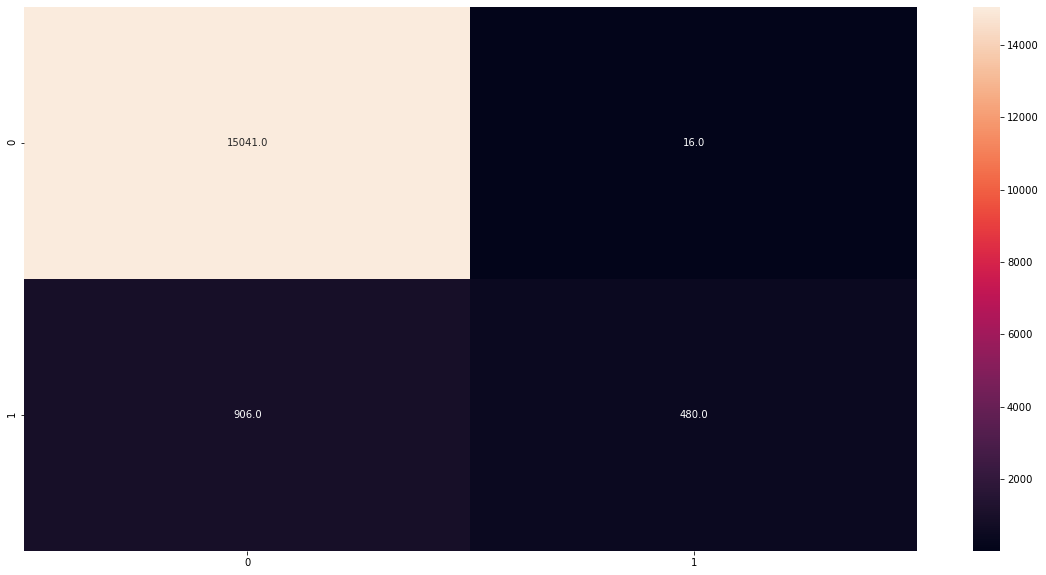

In [40]:
confu(y_test,y_test_pred_light)

## Algorithms retrospection 

### decision tree 

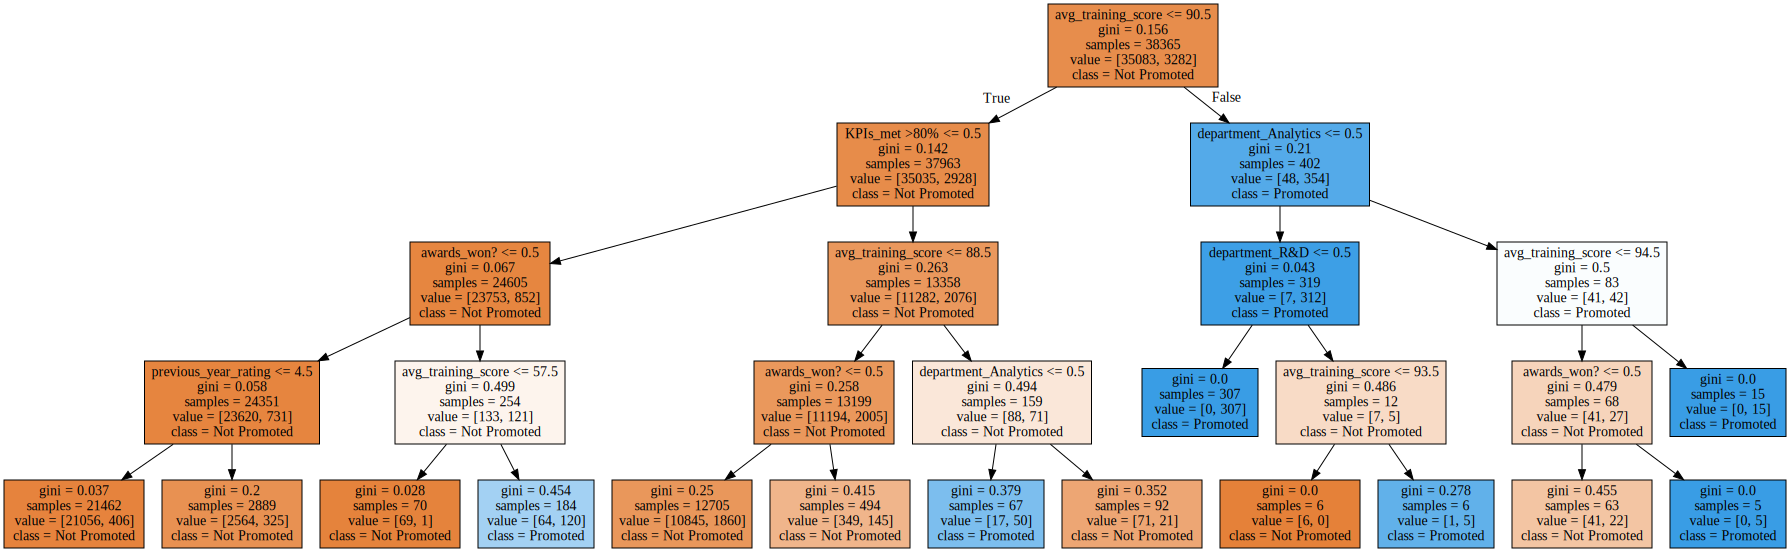

In [48]:
def plot_tree(tree, features, labels):
    #dotfile = open("dtree2.dot", 'w')
    graph = Source(export_graphviz(tree, feature_names=features, class_names=labels, filled = True,out_file = None))
    graph.format= 'png'
    graph.render('dtree_render',view=True)
    display(SVG(graph.pipe(format='svg')))
    


plot_tree(clf_tree, features=X_train.columns, labels=['Not Promoted', 'Promoted'])




In [49]:
print(classification_report(y_test,y_test_pred_tree))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     15057
           1       0.86      0.17      0.28      1386

    accuracy                           0.93     16443
   macro avg       0.89      0.58      0.62     16443
weighted avg       0.92      0.93      0.90     16443



### Random Forest - Feature Importance

In [50]:
feature_importances = clf_rf.feature_importances_
#features = best[-1]
features = X_train.columns
stats = pd.DataFrame({'feature':features, 'importance':feature_importances})
stats.head(10)

,feature,importance
0,age,0.003335
1,previous_year_rating,0.084669
2,KPIs_met >80%,0.222650
3,awards_won?,0.169953
4,avg_training_score,0.476948
5,education_Bachelor's,0.002531
6,recruitment_channel_referred,0.001365
7,department_Analytics,0.011974
8,department_Finance,0.000776
9,department_HR,0.001526


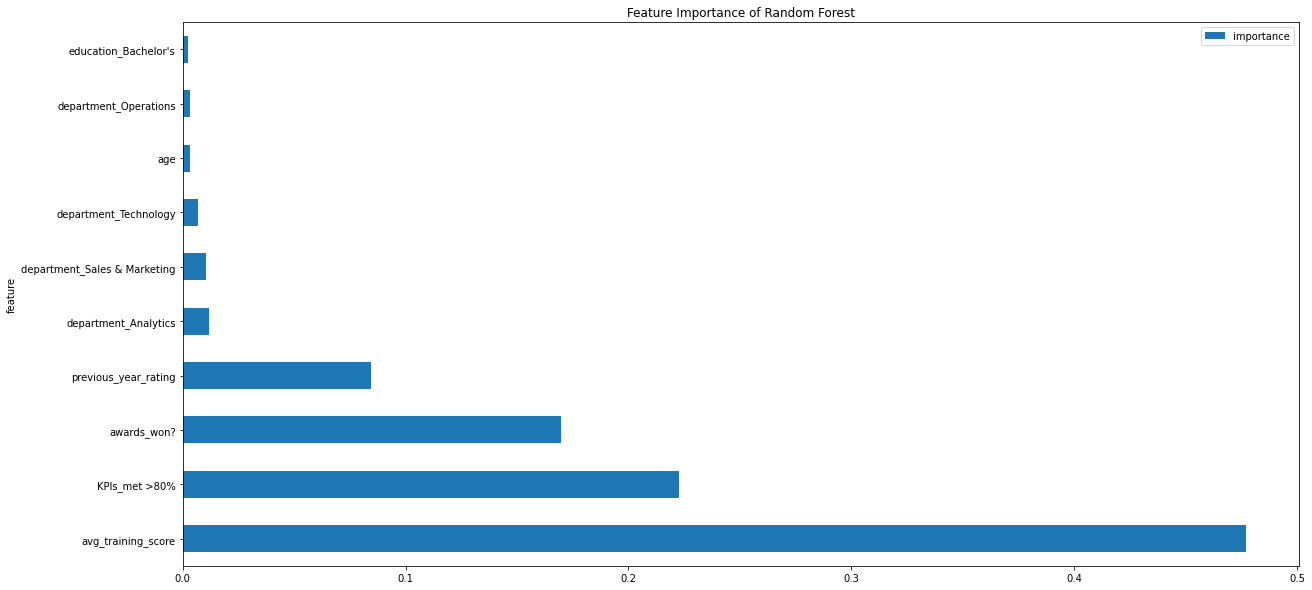

In [51]:
top_10 = stats.sort_values('importance', ascending=False).head(10)
top_10.plot(y='importance', x='feature', kind='barh')
plt.title('Feature Importance of Random Forest');

## 	Hyperparameters

In [52]:
n_estimators_values = [70, 100, 120, 140, 180, 200, 220, 250, 280, 300, 325, 375, 400, 425, 450, 500]
results = pd.DataFrame()
lst = []
best_score = 0
for n in tqdm(n_estimators_values):
    for i in range(2,8):
        y_train_pred,y_test_pred, f1 ,precision, recall,t_auc, clf = foo3(XGBClassifier(n_estimators=n,
                                                                                        max_depth=i,
                                                                                        scale_pos_weight=2,
                                                                                       verbosity=0),
                                                                          X_train, X_test, y_train, y_test)
        lst.append([f1,i,n,precision,recall,t_auc])
        if f1>best_score:
            best_score = f1
            best_hyper = y_train_pred,y_test_pred, f1 ,precision, recall,t_auc, clf

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:04<00:00,  4.06s/it]


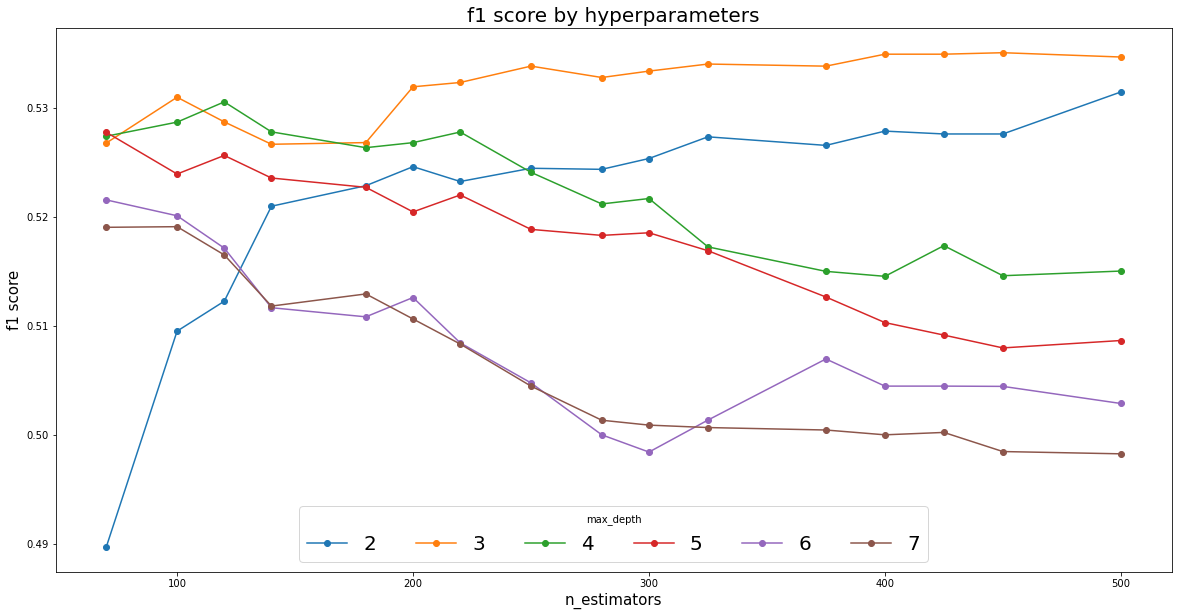

In [53]:
df = pd.DataFrame(lst,columns=['f1','max_depth','n_estimators','precision','recall','t_auc'])
groups = df.groupby('max_depth')
for name, group in groups:
    plt.plot(group["n_estimators"], group["f1"], marker="o", linestyle="solid", label=name)
plt.legend(loc='lower center',prop={'size': 20},ncol=6,title='max_depth')
plt.title('f1 score by hyperparameters',size=20)
plt.xlabel('n_estimators',size=15)
plt.ylabel('f1 score',size=15)
plt.show()

In [54]:
temp = df[df.index==df.f1.idxmax()]

In [ ]:
temp

### Different  sample sizes

In [ ]:
ratios = np.array([0.1,0.3,0.5,0.7,0.9])
best_f1 = 0
accuracy = []
for ratio in ratios:
    X_train, X_test, y_train, y_test = foo2(best[-1],y,ratio)
    y_train_pred,y_test_pred, f1 ,precision, recall,t_auc, clf  = foo3(XGBClassifier(n_estimators=temp['n_estimators'].values[0],
                                                                                     max_depth=temp['max_depth'].values[0],
                                                                                    scale_pos_weight=2,
                                                                                    verbosity=0),
                                                                       X_train, X_test, y_train, y_test)
    if f1>best_f1:
        bestybest = (y_test,y_test_pred), f1 ,precision, recall,t_auc
        best_f1 = f1
    accuracy.append(f1)

plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(ratios, accuracy, 'y')
plt.xticks(ratios)
plt.xlabel('Size')
plt.ylabel('Accuracy')
plt.title('Accuracies for given size', fontsize=20)
plt.show()

In [ ]:
print(f'f1: {bestybest[1]}\nprecision:{bestybest[-3]}\nrecall: {bestybest[-2]}\nt_auc: {bestybest[-1]}')

In [ ]:
confu(bestybest[0][0],bestybest[0][1])